In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

from rpy2.robjects import r

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R -o counts -o cells -o batch

suppressMessages(library(splatter))

params <- newSplatParams()

params <- setParam(params, "nGenes", 2000)
params <- setParam(params, "batchCells", c(1000, 1000, 2000))
params <- setParam(params, "batch.facLoc", 0.3)
params <- setParam(params, "batch.facScale", 0.3)
params <- setParam(params, "group.prob", c(1/4, 1/4, 1/4, 1/4))

sim <- splatSimulate(params, method="groups", verbose=FALSE)

counts <- data.frame(counts(sim))
cells <- colData(sim)[,"Group"]
batch <- colData(sim)[,"Batch"]

In [5]:
counts = np.array(counts)
meta = pd.DataFrame({'cells': cells, 'batch': batch} , dtype="str", index = range(0, len(cells)))

In [6]:
adata = ad.AnnData(X = counts.T, obs = meta)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

Transforming to str index.


... storing 'cells' as categorical
... storing 'batch' as categorical


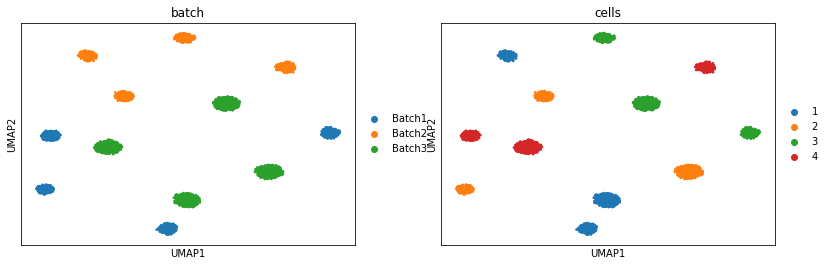

In [7]:
sc.pl.umap(adata,color=['batch','cells'])

In [8]:
adata = adata[np.random.choice(adata.obs_names, adata.shape[0], replace = False)]

In [9]:
from bbtnn.tnn_v3 import *

In [10]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 2, verbose = 2, save_on_disk = False)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (1, 2)
2473 cells defined as MNNs
Calculating KNNs
1527 cells defined as KNNs


W0326 15:46:34.017428 13744 deprecation.py:323] From C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4075: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0326 15:46:34.149106 13744 deprecation.py:506] From C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Training neural network
Epoch 1/1000
125/125 - 3s - loss: 1.4249
Epoch 2/1000
125/125 - 1s - loss: 1.1637
Epoch 3/1000
125/125 - 1s - loss: 1.0588
Epoch 4/1000
125/125 - 1s - loss: 0.8940
Epoch 5/1000
125/125 - 1s - loss: 0.7693
Epoch 6/1000
125/125 - 1s - loss: 0.6697
Epoch 7/1000
125/125 - 1s - loss: 0.6064
Epoch 8/1000
125/125 - 1s - loss: 0.5979
Epoch 9/1000
125/125 - 1s - loss: 0.5491
Epoch 10/1000
125/125 - 1s - loss: 0.4920
Epoch 11/1000
125/125 - 1s - loss: 0.4398
Epoch 12/1000
125/125 - 1s - loss: 0.4153
Epoch 13/1000
125/125 - 1s - loss: 0.4261
Epoch 14/1000
125/125 - 1s - loss: 0.3800
Epoch 15/1000
125/125 - 1s - loss: 0.3794
Epoch 16/1000
125/125 - 1s - loss: 0.3314
Epoch 17/1000
125/125 - 1s - loss: 0.3415
Epoch 18/1000
125/125 - 1s - loss: 0.3422
4000/4000 - 0s
Wall time: 21.5 s


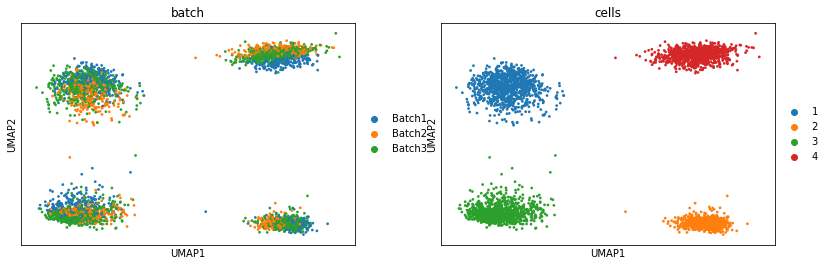

In [11]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "cells"])

In [12]:
bdata = adata[~((adata.obs["batch"] == "Batch1") & (adata.obs["cells"] =="4"))]
bdata = bdata[~((bdata.obs["batch"] == "Batch2") & (bdata.obs["cells"] =="4"))]

In [13]:
bdata

View of AnnData object with n_obs × n_vars = 3481 × 2000 
    obs: 'cells', 'batch', 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'batch_colors', 'cells_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [14]:
sc.tl.pca(bdata)
sc.pp.neighbors(bdata, n_neighbors=10)
sc.tl.umap(bdata)

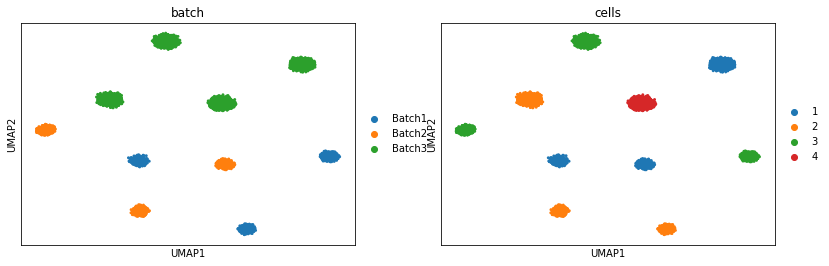

In [15]:
sc.pl.umap(bdata, color = ["batch", "cells"])

In [16]:
%%time
model = TNN(k = 20, batch_size = 32, n_epochs_without_progress = 2, verbose = 0, save_on_disk = False)
model.fit(X = bdata, batch_name = "batch", Y = None)
embedding = model.transform(X = bdata)

Processing datasets (0, 1)
Processing datasets (1, 2)
Wall time: 17.2 s


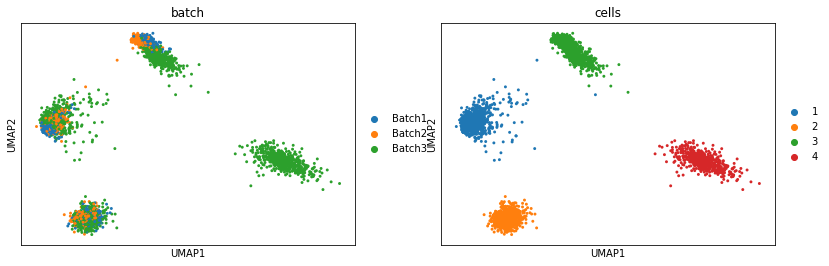

In [17]:
bdata.obsm["X_umap"] = embedding
sc.pl.umap(bdata, color = ["batch", "cells"])

Processing datasets (0, 1)
Processing datasets (1, 2)


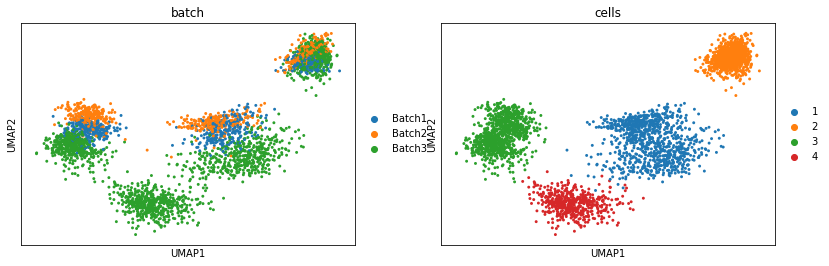

Processing datasets (0, 1)
Processing datasets (1, 2)


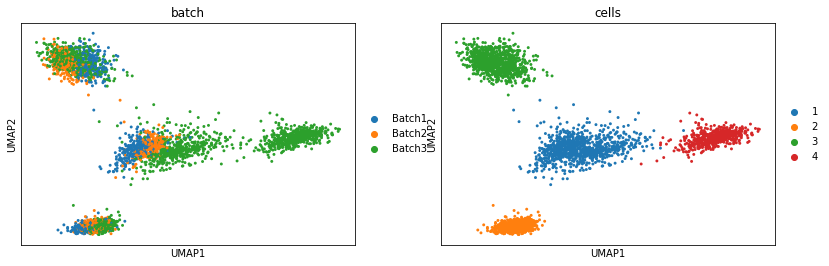

Processing datasets (0, 1)
Processing datasets (1, 2)


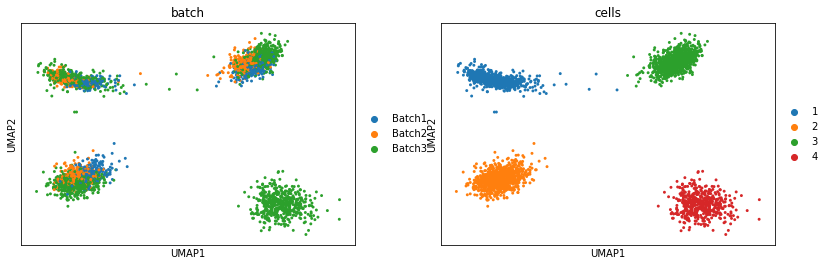

Processing datasets (0, 1)
Processing datasets (1, 2)


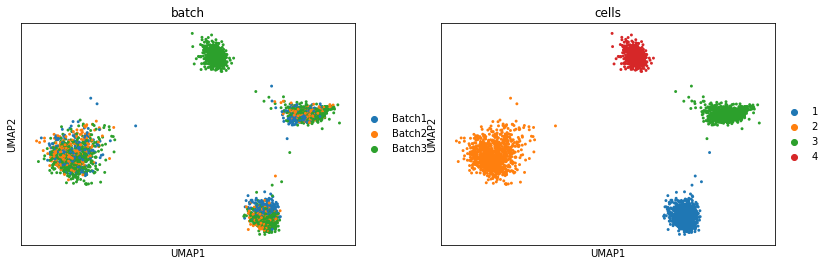

Processing datasets (0, 1)
Processing datasets (1, 2)


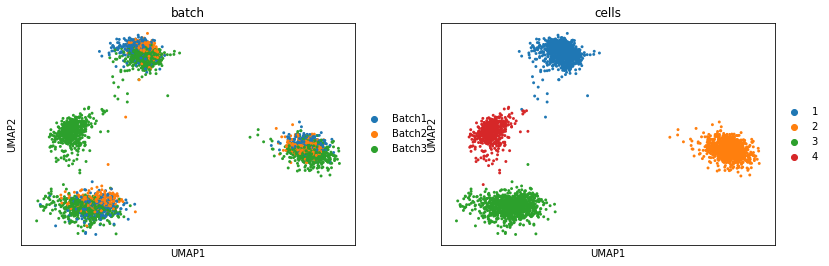

In [27]:
from bbtnn.tnn_v3 import *
for k in [10, 20, 50, 100, 200]:
    model = TNN(k = k, batch_size = 32, n_epochs_without_progress = 2, verbose = 0)
    model.fit(X = bdata, batch_name = "batch", Y = None)
    embedding = model.transform(X = bdata)
    bdata.obsm["X_umap"] = embedding
    sc.pl.umap(bdata, color = ["batch", "cells"])

[[0.         0.06056528 0.16260163]
 [0.         0.         0.07723577]
 [0.         0.         0.        ]]
2956
******Batches:[Batch1, Batch3, Batch2]
Categories (3, object): [Batch1, Batch3, Batch2]
******Total number of cells:3481
******Number of cells for MNN:525


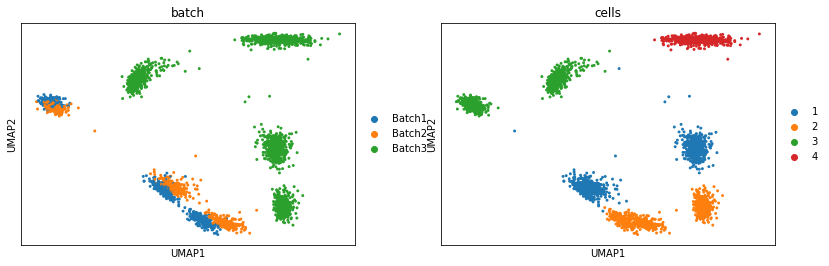

[[0.         0.1125     0.29674797]
 [0.         0.         0.13821138]
 [0.         0.         0.        ]]
2505
******Batches:[Batch1, Batch3, Batch2]
Categories (3, object): [Batch1, Batch3, Batch2]
******Total number of cells:3481
******Number of cells for MNN:976


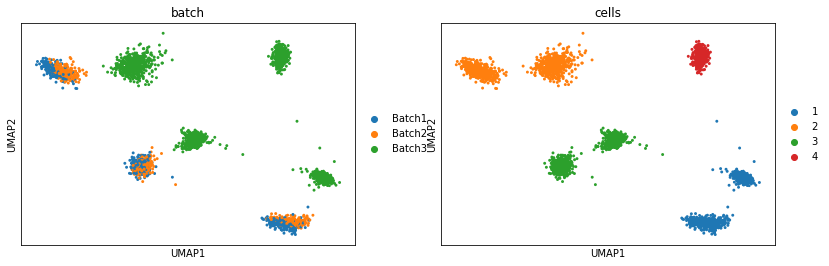

[[0.         0.30686406 0.55284553]
 [0.         0.         0.32249322]
 [0.         0.         0.        ]]
1732
******Batches:[Batch1, Batch3, Batch2]
Categories (3, object): [Batch1, Batch3, Batch2]
******Total number of cells:3481
******Number of cells for MNN:1749


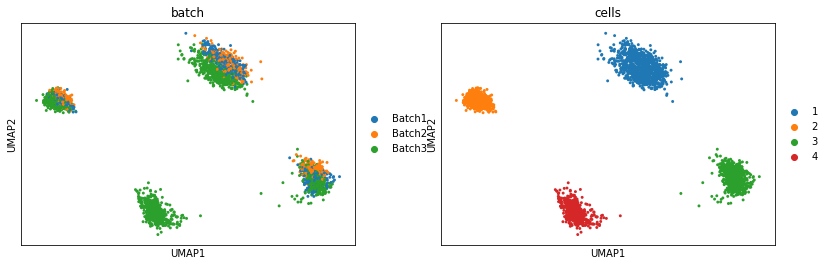

[[0.         0.64199192 0.7696477 ]
 [0.         0.         0.69512195]
 [0.         0.         0.        ]]
1141
******Batches:[Batch1, Batch3, Batch2]
Categories (3, object): [Batch1, Batch3, Batch2]
******Total number of cells:3481
******Number of cells for MNN:2340


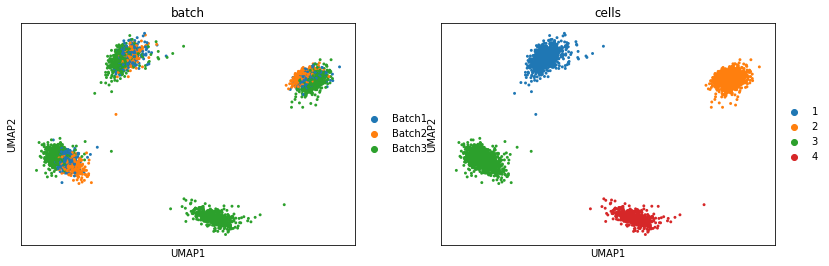

[[0.         0.90040377 0.90921409]
 [0.         0.         0.91463415]
 [0.         0.         0.        ]]
691
******Batches:[Batch1, Batch3, Batch2]
Categories (3, object): [Batch1, Batch3, Batch2]
******Total number of cells:3481
******Number of cells for MNN:2790


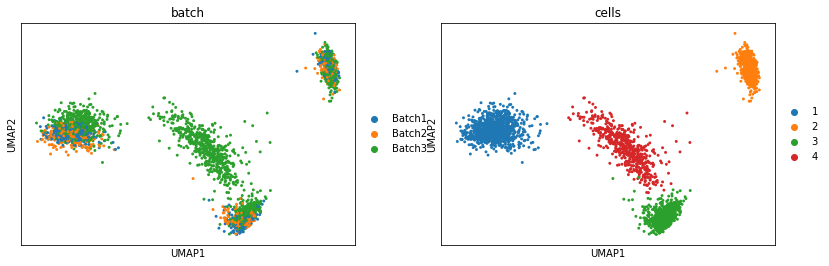

In [26]:
from bbtnn.tnn import *
for k in [10, 20, 50, 100, 200]:
    model = TNN(k = k, batch_size = 32, n_epochs_without_progress = 2, verbose = 0)
    model.fit(X = bdata, Y = None)
    embedding = model.transform(X = bdata)
    bdata.obsm["X_umap"] = embedding
    sc.pl.umap(bdata, color = ["batch", "cells"])

In [12]:
from bbtnn.tnn import *

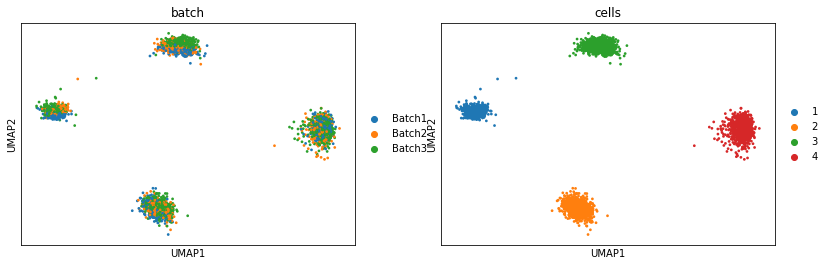

In [12]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "cells"])

In [24]:
%%time
model = tnn.TNN(k = 10, batch_size = 32, n_epochs_without_progress = 2, verbose = 2)
model.fit(X = bdata, Y = None)
embedding = model.transform(X = bdata)

[[0.         0.06910569 0.1598916 ]
 [0.         0.         0.0551817 ]
 [0.         0.         0.        ]]
2984
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:3481
******Number of cells for MNN:497
Training neural network
Epoch 1/1000
109/109 - 3s - loss: 1.1181
Epoch 2/1000
109/109 - 1s - loss: 0.8498
Epoch 3/1000
109/109 - 1s - loss: 0.7683
Epoch 4/1000
109/109 - 1s - loss: 0.7136
Epoch 5/1000
109/109 - 1s - loss: 0.6968
Epoch 6/1000
109/109 - 1s - loss: 0.6212
Epoch 7/1000
109/109 - 1s - loss: 0.5682
Epoch 8/1000
109/109 - 1s - loss: 0.5067
Epoch 9/1000
109/109 - 1s - loss: 0.4694
Epoch 10/1000
109/109 - 1s - loss: 0.4331
Epoch 11/1000
109/109 - 1s - loss: 0.4065
Epoch 12/1000
109/109 - 1s - loss: 0.3792
Epoch 13/1000
109/109 - 1s - loss: 0.3640
Epoch 14/1000
109/109 - 1s - loss: 0.3514
Epoch 15/1000
109/109 - 1s - loss: 0.3241
Epoch 16/1000
109/109 - 1s - loss: 0.3139
Epoch 17/1000
109/109 - 1s - loss: 0.3128
Ep

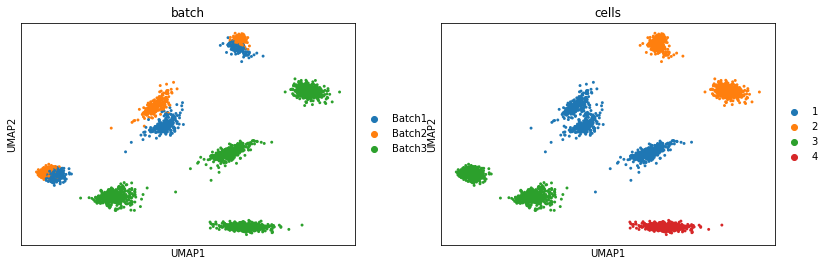

In [25]:
bdata.obsm["X_umap"] = embedding
sc.pl.umap(bdata, color = ["batch", "cells"])

In [25]:
from bbtnn import tnn_v2

In [45]:
%%time
model = tnn_v2.TNN(k = 25, batch_size = 32, n_epochs_without_progress = 2, verbose = 2)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Calculate MNN pairs
(0, 1)
(0, 2)
(1, 2)
Reformat MNN pairs
Calculate KNN neighborhood
******Batches:[Batch3, Batch1, Batch2]
Categories (3, object): [Batch3, Batch1, Batch2]
******Total number of cells:10000
******Number of cells for MNN:2692
******Number of cells for KNN:7308
Sort cells
Training neural network
Epoch 1/1000
313/313 - 3s - loss: 1.3886
Epoch 2/1000
313/313 - 1s - loss: 1.1445
Epoch 3/1000
313/313 - 1s - loss: 1.1232
Epoch 4/1000
313/313 - 1s - loss: 1.1018
Epoch 5/1000
313/313 - 1s - loss: 1.0858
Epoch 6/1000
313/313 - 1s - loss: 1.0791
Epoch 7/1000
313/313 - 1s - loss: 1.0713
Epoch 8/1000
313/313 - 1s - loss: 1.0638
Epoch 9/1000
313/313 - 1s - loss: 1.0574
Epoch 10/1000
313/313 - 1s - loss: 1.0495
Epoch 11/1000
313/313 - 1s - loss: 1.0453
Epoch 12/1000
313/313 - 1s - loss: 1.0418
Epoch 13/1000
313/313 - 1s - loss: 1.0399
Epoch 14/1000
313/313 - 1s - loss: 1.0370
Epoch 15/1000
313/313 - 1s - loss: 1.0320
Epoch 16/1000
313/313 - 1s - loss: 1.0285
Epoch 17/1000
313/313 -

In [16]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "cells"])

ValueError: Value passed for key 'X_umap' is of incorrect shape. Values of obsm must match dimensions (0,) of parent. Value had shape (8512, 2) while it should have had (10000,).

In [53]:
%%time
model = tnn_v2.TNN(k = 100, batch_size = 32, n_epochs_without_progress = 2, verbose = 2)
model.fit(X = bdata, batch_name = "batch", Y = None)
embedding = model.transform(X = bdata)

Calculate MNN pairs
(0, 1)
(0, 2)
(1, 2)
Reformat MNN pairs
Calculate KNN neighborhood
******Batches:[Batch3, Batch1, Batch2]
Categories (3, object): [Batch3, Batch1, Batch2]
******Total number of cells:8512
******Number of cells for MNN:4796
******Number of cells for KNN:3716
Sort cells
Training neural network
Epoch 1/1000
266/266 - 3s - loss: 1.3860
Epoch 2/1000
266/266 - 1s - loss: 1.1405
Epoch 3/1000
266/266 - 1s - loss: 1.1185
Epoch 4/1000
266/266 - 1s - loss: 1.1030
Epoch 5/1000
266/266 - 1s - loss: 1.0924
Epoch 6/1000
266/266 - 1s - loss: 1.0802
Epoch 7/1000
266/266 - 1s - loss: 1.0695
Epoch 8/1000
266/266 - 1s - loss: 1.0316
Epoch 9/1000
266/266 - 1s - loss: 0.9586
Epoch 10/1000
266/266 - 1s - loss: 0.9104
Epoch 11/1000
266/266 - 1s - loss: 0.8667
Epoch 12/1000
266/266 - 1s - loss: 0.8454
Epoch 13/1000
266/266 - 1s - loss: 0.8259
Epoch 14/1000
266/266 - 1s - loss: 0.8297
Epoch 15/1000
266/266 - 1s - loss: 0.8165
Epoch 16/1000
266/266 - 1s - loss: 0.7946
Epoch 17/1000
266/266 - 

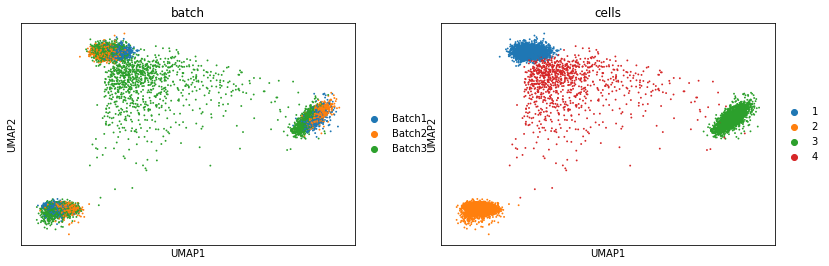

In [54]:
bdata.obsm["X_umap"] = embedding
sc.pl.umap(bdata, color = ["batch", "cells"])

In [22]:
def nn_approx(ds1, ds2, names1, names2, knn = 20, metric='euclidean', n_trees = 50):
    # Build index.
    a = AnnoyIndex(ds2.shape[1], metric=metric)
    #a.on_disk_build('annoy.index')
    for i in range(ds2.shape[0]):
        a.add_item(i, ds2[i, :])
    a.build(n_trees)

    # Search index.
    ind = []
    for i in range(ds1.shape[0]):
        ind.append(a.get_nns_by_vector(ds1[i, :], knn, search_k=-1))
    ind = np.array(ind)

    # Match.
    match = set()
    for a, b in zip(range(ds1.shape[0]), ind):
        for b_i in b:
            match.add((names1[a], names2[b_i]))

    return match


def mnn(ds1, ds2, names1, names2, knn = 20):
    # Find nearest neighbors in first direction.
    match1 = nn_approx(ds1, ds2, names1, names2, knn=knn)  #should be a list
    # Find nearest neighbors in second direction.
    match2 = nn_approx(ds2, ds1, names2, names1, knn=knn)
    
    # Compute mutual nearest neighbors.
    mutual = match1 & set([ (b, a) for a, b in match2 ])

    return mutual

In [116]:
def create_dictionary_mnn(adata, batch_name, k = 50):

    cell_names = adata.obs_names

    batch_list = adata.obs[batch_name]
    datasets = []
    datasets_pcs = []
    cells = []
    for i in batch_list.unique():
        datasets.append(adata[batch_list == i])
        datasets_pcs.append(adata[batch_list == i].obsm["X_pca"])
        cells.append(cell_names[batch_list == i])

    mnns = dict()
    for i in range(len(datasets) - 1):
        j = i + 1

        print('Processing datasets {}'.format((i, j)))

        new = list(cells[j])
        ref = []
        for x in range(j):
            ref += list(cells[x])

        ds1 = adata[new].obsm['X_pca']
        ds2 = adata[ref].obsm['X_pca']
        names1 = new
        names2 = ref
        match = mnn(ds1, ds2, names1, names2, knn=k)

        G = nx.Graph()
        G.add_edges_from(match)
        node_names = np.array(G.nodes)
        anchors = list(node_names)
        adj = nx.adjacency_matrix(G)

        tmp = np.split(adj.indices, adj.indptr[1:-1])

        for i in range(0, len(anchors)):
            key = anchors[i]
            i = tmp[i]
            names = list(node_names[i])
            mnns[key] = names

    return(mnns)


def create_dictionary_knn(adata, cells_for_knn, k = 50):

    cell_names = adata.obs_names

    dataset = adata[cells_for_knn]
    dataset_ref = dataset.obsm['X_pca']
    
    a = AnnoyIndex(dataset_ref.shape[1], metric='euclidean')
    #a.on_disk_build('annoy.index')
    for i in range(dataset_ref.shape[0]):
        a.add_item(i, dataset_ref[i, :])
    a.build(50)

    # Search index.
    knns = dict()
    for i in range(dataset_ref.shape[0]):
        indices = a.get_nns_by_vector(dataset_ref[i, :], k, search_k=-1)[1:]
        key = cells_for_knn[i]
        names = np.array(cells_for_knn)[indices]
        knns[key] = names
    
    return(knns)

In [144]:
def generator_from_index(adata, k = 20, k_to_m_ratio = 0.75, batch_size = 32, search_k=-1,
                         precompute=True, verbose=1):

    cell_names = adata.obs_names

    mnn_dict = create_dictionary_mnn(adata, batch_name, k = k)
    
    num_k = round(k_to_m_ratio * len(mnn_dict))
    
    cells_for_knn = list(set(cell_names) - set(list(mnn_dict.keys())))
    if(len(cells_for_knn) > num_k):
        cells_for_knn = np.random.choice(cells_for_knn, num_k, replace = False)

    knn_dict = create_dictionary_knn(adata, cells_for_knn, k = k)

    final_dict = mnn_dict
    final_dict.update(knn_dict)

    cells = list(final_dict.keys())

    bdata = adata[cells]

    triplet_list = []
    for i in cells:
        names = final_dict[i]
        triplet_list.append([bdata.obs_names.get_loc(x) for x in names])

    return KnnTripletGenerator(X = bdata.obsm["X_pca"], dictionary = triplet_list, batch_size=batch_size)


In [137]:
batch_name = "batch"
k = 50

cell_names = adata.obs_names

mnn_dict = create_dictionary_mnn(adata, batch_name, k = k)

cells_for_knn = list(set(cell_names) - set(list(mnn_dict.keys())))
if(len(cells_for_knn) > len(mnn_dict)):
    cells_for_knn = np.random.choice(cells_for_knn, round(0.75*len(mnn_dict)), replace = False)

knn_dict = create_dictionary_knn(adata, cells_for_knn, k = k)

final_dict = mnn_dict
final_dict.update(knn_dict)

cells = list(final_dict.keys())

bdata = adata[cells]

triplet_list = []
for i in cells:
    names = final_dict[i]
    triplet_list.append([bdata.obs_names.get_loc(x) for x in names])

Processing datasets (0, 1)
Processing datasets (1, 2)


In [138]:
#adata = adata[cells]
X = bdata.obsm["X_pca"]
dictionary = triplet_list
batch_size = 32

In [139]:
class KnnTripletGenerator(Sequence):

    def __init__(self, X, dictionary, batch_size=32):
        self.X = X
        self.batch_size = batch_size
        self.dictionary = dictionary
        self.placeholder_labels = np.empty(batch_size, dtype=np.uint8)
        self.num_cells = len(self.dictionary)

    def __len__(self):
        return int(np.ceil(len(self.dictionary) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_indices = range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.num_cells))


        triplet_batch = [self.knn_triplet_from_dictionary(row_index = row_index, neighbour_list = self.dictionary[row_index], num_cells = self.num_cells) for row_index in batch_indices]

        if (issparse(self.X)):
            triplet_batch = [[e.toarray()[0] for e in t] for t in triplet_batch]

        triplet_batch = np.array(triplet_batch)
        placeholder_labels = self.placeholder_labels[:triplet_batch.shape[0]]

        return tuple([triplet_batch[:, 0], triplet_batch[:, 1], triplet_batch[:, 2]]), placeholder_labels

    def knn_triplet_from_dictionary(self, row_index, neighbour_list, num_cells):
        """ A random (unweighted) positive example chosen. """
        triplets = []

        anchor = row_index
        positive = np.random.choice(neighbour_list)
        negative = np.random.randint(self.num_cells)

        triplets += [self.X[anchor], self.X[positive],
                     self.X[negative]]

        return triplets

In [140]:
def generate_triplets(row_index, neighbour_list, X, num_cells):
        """ A random (unweighted) positive example chosen. """
        triplets = []

        anchor = row_index
        positive = np.random.choice(neighbour_list)
        negative = np.random.randint(num_cells)

        triplets += [X[anchor], X[positive],
                     X[negative]]

        return triplets

triplets = [generate_triplets(row_index = row_index, neighbour_list = triplet_list[row_index], X = X, num_cells = adata.shape[0]) for row_index in range(0, len(triplet_list))]
triplets = np.array(triplets)